In [1]:
import os, shutil, h5py
from tqdm import tqdm
import tensorboard
import sys
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import zipfile
import glob
import datetime

In [2]:
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    # compute duration of an epoch
    return round(time_per_training_step, 2)

# Load the data from memory

## Load the data

In [3]:
class generator:
    def __init__(self, file, batch_size):
        self.file = file
        self._f = None
        self.batch_size = batch_size
        
    def openf(self):
        self._f = h5py.File(self.file, 'r')
        self._nevents = self._f['labels'].shape[0]
        return self._nevents
    
    def closef(self):
        try:
            self._f.close()
        except AttributeError:
            print('hdf5 file is not open yet.')
    
    def __call__(self):
        
        nevents = self.openf()

        for i in range(0, nevents, self.batch_size):
            yield self._f["samples"][i:i+self.batch_size, :, :], self._f["labels"][i:i+self.batch_size]
        
        self.closef()

### Jupyter notebook initialization

In [17]:
path = 'D:/Automatic Artifact Detection in EEG recordings/data/prep_normal/T_2_T_002_10_currentAndPrevious'
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_generator(
    generator(f"{path}/train_dataset.hdf5", BATCH_SIZE),
    output_types=(tf.float32, tf.bool), output_shapes=((None, 500, 22), (None))
    )

val_dataset = tf.data.Dataset.from_generator(
    generator(f"{path}/val_dataset.hdf5", BATCH_SIZE),
    output_types=(tf.float32, tf.bool), output_shapes=((None, 500, 22), (None))
    )

test_dataset = tf.data.Dataset.from_generator(
    generator(f"{path}/test_dataset.hdf5", BATCH_SIZE),
    output_types=(tf.float32, tf.bool), output_shapes=((None, 500, 22), (None))
    )

### Google Colab initialization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
path = '/content/gdrive/MyDrive/dataset/F_2_T_002_10'
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_generator(
    generator(f"{path}/train_dataset.hdf5", BATCH_SIZE),
    output_types=(tf.float32, tf.bool), output_shapes=((None, 500, 22), (None))
    )

val_dataset = tf.data.Dataset.from_generator(
    generator(f"{path}/val_dataset.hdf5", BATCH_SIZE),
    output_types=(tf.float32, tf.bool), output_shapes=((None, 500, 22), (None))
    )

test_dataset = tf.data.Dataset.from_generator(
    generator(f"{path}/test_dataset.hdf5", BATCH_SIZE),
    output_types=(tf.float32, tf.bool), output_shapes=((None, 500, 22), (None))
    )

## Prefetch and shuffle the datasets

No standardization

In [18]:
# train dataset
train_dataset = train_dataset.map(lambda sample, label: (tf.expand_dims(sample, axis=-1),  tf.cast(label, tf.float32)))
# validation dataset
val_dataset = val_dataset.map(lambda sample, label: (tf.expand_dims(sample, axis=-1), tf.cast(label, tf.float32)))
# test dataset
test_dataset = test_dataset.map(lambda sample, label: (tf.expand_dims(sample, axis=-1), tf.cast(label, tf.float32)))

# shuffle
train_dataset = train_dataset.shuffle(buffer_size=32)
val_dataset = val_dataset.shuffle(buffer_size=32)
test_dataset = test_dataset.shuffle(buffer_size=32)

# prefetch
train_dataset = train_dataset.prefetch(32)
val_dataset = val_dataset.prefetch(32)
test_dataset = test_dataset.prefetch(32)

Standardization

In [5]:
# train dataset
train_dataset = train_dataset.map(lambda sample, label: ((sample - tf.math.reduce_mean(sample, axis=1, keepdims=True))/tf.math.reduce_std(sample, axis=1, keepdims=True),  tf.cast(label, tf.float32)))
train_dataset = train_dataset.map(lambda sample, label: (tf.expand_dims(sample, axis=-1), label))
# validation dataset
val_dataset = val_dataset.map(lambda sample, label: ((sample - tf.math.reduce_mean(sample, axis=1, keepdims=True))/tf.math.reduce_std(sample, axis=1, keepdims=True), tf.cast(label, tf.float32)))
val_dataset = val_dataset.map(lambda sample, label: (tf.expand_dims(sample, axis=-1), label))
# test dataset
test_dataset = test_dataset.map(lambda sample, label: ((sample - tf.math.reduce_mean(sample, axis=1, keepdims=True))/tf.math.reduce_std(sample, axis=1, keepdims=True), tf.cast(label, tf.float32)))
test_dataset = test_dataset.map(lambda sample, label: (tf.expand_dims(sample, axis=-1), label))

# shuffle
train_dataset = train_dataset.shuffle(buffer_size=32)
val_dataset = val_dataset.shuffle(buffer_size=32)
test_dataset = test_dataset.shuffle(buffer_size=32)

# prefetch
train_dataset = train_dataset.prefetch(32)
val_dataset = val_dataset.prefetch(32)
test_dataset = test_dataset.prefetch(32)

## Plot example EEG chunk

In [19]:
# print x random images from the given dataset
def print_x_signals_from_ds(dataset, number_signals):
    plt.style.use("ggplot")
    fig, ax = plt.subplots(nrows=number_signals, figsize=(7, 10))
    for i, (sample, label) in enumerate(dataset.take(number_signals)):
        ax[i].plot(sample[0, :, :, 0])
        ax[i].set_title(f'Artifact = {tf.cast(label[0], tf.bool)}')
        ax[i].set_ylabel("Amplitude")
        ax[i].set_xlabel("Time [1/250 s]")
    plt.tight_layout()
    plt.show()

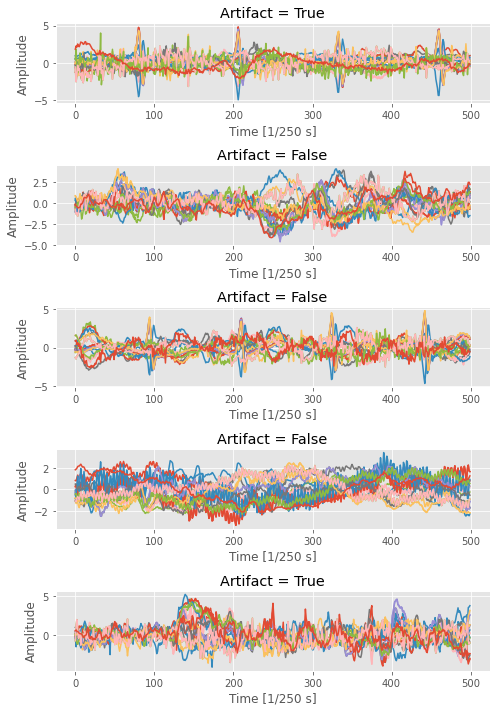

In [20]:
print_x_signals_from_ds(train_dataset, 5)

# Model

In [21]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class LSTM(Model):
    
    def __init__(self):
        super(LSTM, self).__init__()

        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(5,1), strides=(5,1))
        self.lstm1 = tf.keras.layers.LSTM(units=100, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(units=100, return_sequences=True)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)
        self.dense2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)
        self.readout = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)

    @tf.function
    def call(self, x):

        # Define forward step
        x = self.avg_pool(x)
        x = tf.squeeze(x, axis=-1)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.readout(x)

        return x

In [22]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, val_data, loss_function):
    # test over complete val_data
    val_accuracy_aggregator = []
    val_loss_aggregator = []

    for (input, target) in tqdm(val_data):
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        
        # compute mean of fitting preditions in this batch
        sample_test_accuracy = np.mean(abs(target - tf.squeeze(prediction, axis=-1)) < 0.5)
        
        val_loss_aggregator.append(sample_test_loss.numpy())
        val_accuracy_aggregator.append(sample_test_accuracy)

    val_loss = np.mean(val_loss_aggregator)
    val_accuracy = np.mean(val_accuracy_aggregator)

    return val_loss, val_accuracy

In [23]:
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
lstm_log_dir = 'logs/gradient_tape/' + current_time + '/lstm'
lstm_summary_writer = tf.summary.create_file_writer(lstm_log_dir)
tf.keras.backend.clear_session()

def train(model, num, train_dataset, val_dataset):
    ### Hyperparameters
    num_epochs = num
    learning_rate = 0.0001
    running_average_factor = 0.95

    # Initialize the loss: binary cross entropy. Check out 'tf.keras.losses'.
    binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
    # Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Initialize lists for later visualization.
    train_losses = []

    val_losses = []
    val_accuracies = []

    #testing once before we begin
    val_loss, val_accuracy = test(model, val_dataset, binary_crossentropy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    #check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, binary_crossentropy)
    train_losses.append(train_loss)

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):

        print(f"Epoch: {epoch}")

        train_dataset = train_dataset.shuffle(buffer_size=128)
        val_data = val_dataset.shuffle(buffer_size=128)

        #training (and checking in with training)
        running_average = 0
        for (input,target) in tqdm(train_dataset):
            train_loss = train_step(model, input, target, binary_crossentropy, optimizer)
            running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
        train_losses.append(running_average)

        #testing
        val_loss, val_accuracy = test(model, val_dataset, binary_crossentropy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        with lstm_summary_writer.as_default():
            tf.summary.scalar("train_loss", train_losses[-1], step=epoch)

        with lstm_summary_writer.as_default():
            tf.summary.scalar("val_loss", val_losses[-1], step=epoch)

        with lstm_summary_writer.as_default():
            tf.summary.scalar("val_accuracies", val_accuracies[-1], step=epoch)
            
        model.save_weights("LSTM_large.h5") if val_accuracy == max(val_accuracies) else None

        print(f"train loss: {running_average}, validation loss: {val_loss}, validation accuracy: {val_accuracy}", "\n")

## Train model from beginning

In [12]:
# Initialize the model.
model = LSTM()
train(model, 20, train_dataset, val_dataset)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.44549238681793213, validation loss: 0.48836061358451843, validation accuracy: 0.7666903409090909 

Epoch: 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.3398880660533905, validation loss: 0.45386332273483276, validation accuracy: 0.7906351461038961 

Epoch: 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.3561440110206604, validation loss: 0.4551457464694977, validation accuracy: 0.7890371347402597 

Epoch: 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.32096558809280396, validation loss: 0.4388248026371002, validation accuracy: 0.8010349025974026 

Epoch: 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.38197052478790283, validation loss: 0.4542333483695984, validation accuracy: 0.783304586038961 

Epoch: 5


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.3225361108779907, validation loss: 0.4481029808521271, validation accuracy: 0.8002739448051948 

Epoch: 6


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.36707353591918945, validation loss: 0.42609450221061707, validation accuracy: 0.8112824675324676 

Epoch: 7


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.26403313875198364, validation loss: 0.4470955431461334, validation accuracy: 0.8064884334415584 

Epoch: 8


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.2739275097846985, validation loss: 0.4310658574104309, validation accuracy: 0.8035460633116883 

Epoch: 9


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.3460673391819, validation loss: 0.43781301379203796, validation accuracy: 0.8101156655844156 

Epoch: 10


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.2683403491973877, validation loss: 0.44143518805503845, validation accuracy: 0.8109527191558441 

Epoch: 11


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.3552766740322113, validation loss: 0.4388265311717987, validation accuracy: 0.8058035714285714 

Epoch: 12


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.307826429605484, validation loss: 0.4402623474597931, validation accuracy: 0.8047382305194806 

Epoch: 13


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.323957234621048, validation loss: 0.4357357621192932, validation accuracy: 0.7999441964285714 

Epoch: 14


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.3081378638744354, validation loss: 0.45724785327911377, validation accuracy: 0.8051948051948052 

Epoch: 15


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.2446030229330063, validation loss: 0.46208301186561584, validation accuracy: 0.8116375811688312 

Epoch: 16


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.28588899970054626, validation loss: 0.44212424755096436, validation accuracy: 0.8019734172077922 

Epoch: 17


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.25138357281684875, validation loss: 0.4339594542980194, validation accuracy: 0.8127282873376623 

Epoch: 18


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.19858036935329437, validation loss: 0.46316954493522644, validation accuracy: 0.8120434253246753 

Epoch: 19


0it [00:00, ?it/s]

0it [00:00, ?it/s]

train loss: 0.31225770711898804, validation loss: 0.45329397916793823, validation accuracy: 0.8016943993506493 



In [63]:
%load_ext tensorboard
%tensorboard --logdir logs_new/gradient_tape

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6048), started 0:09:58 ago. (Use '!kill 6048' to kill it.)

## Initialize pretrained model

In [24]:
old_model = LSTM()

In [ ]:
_, val_accuracy = test(old_model, val_dataset, loss_function=tf.keras.losses.BinaryCrossentropy())
print(val_accuracy)

In [26]:
old_model.load_weights("weights/Experiment 3/Standardization Previous and Current/LSTM_large.h5")

## Train pretrained model

In [ ]:
# Initialize the model.
train(old_model, 10, train_dataset, val_dataset)

# Performance tests
To test the performance of a pretrained model, please initialize the model with the corresponding weights above.

## Confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def conf_m(model, dataset):
    
    predictions = []
    targets = []
    for (input, target) in tqdm(dataset):

        prediction = np.round(model(input), 0).astype("int")
        prediction = np.asarray(prediction).T[0].tolist()
        target = np.asarray(target, dtype="int").tolist()
        
        predictions.extend(prediction)
        targets.extend(target)
    
    predictions = np.array(predictions, dtype=int)
    targets = np.array(targets, dtype=int)
    
    confm = confusion_matrix(y_true=targets, y_pred=predictions)
    tn, fp, fn, tp = confusion_matrix(y_true=targets, y_pred=predictions).ravel()
    tick_labels = ["False", "True"]
    df_cm = pd.DataFrame(confm, index=tick_labels, columns=tick_labels).reindex(["True", "False"]).T.reindex(["True", "False"]) 
    
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1 = 2 * (precision * recall)/(precision + recall)
    cohen = metrics.cohen_kappa_score(targets, predictions)
    
    return df_cm, accuracy, precision, recall, f1, cohen

In [28]:
df_cm, accuracy, precision, recall, f1, cohen = conf_m(old_model, test_dataset)

0it [00:00, ?it/s]

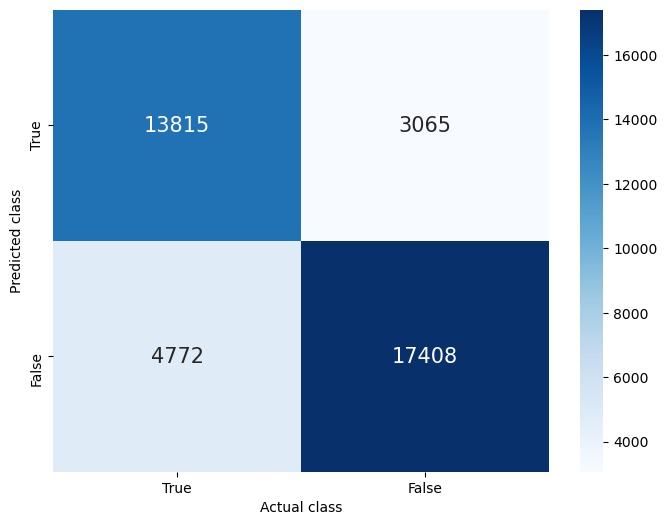

In [29]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fig, ax = plt.subplots(figsize=(8,6))         
ax = sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"fontsize":15}, fmt="d")
ax = ax.set(ylabel = "Predicted class", xlabel="Actual class")
plt.show()

In [30]:
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)
print("Cohen's Kappa: ", cohen)

Accuracy:  0.7993599590373784
Precision:  0.8184241706161137
Recall:  0.7432614192715339
F1:  0.779034031635041
Cohen's Kappa:  0.5960735185702492


In [19]:
loss, accuracy = test(old_model, test_dataset, loss_function=tf.keras.losses.BinaryCrossentropy())
print(f"Loss = {loss}, Accuracy = {accuracy}")

0it [00:00, ?it/s]

Loss = 0.5365753173828125, Accuracy = 0.7637326683644595


## ROC - AUC

In [19]:
def roc(model, dataset):
    
    predictions = []
    targets = []
    for (input, target) in tqdm(dataset):

        prediction = model(input)
        prediction = np.asarray(prediction).T[0].tolist()
        target = np.asarray(target, dtype="int").tolist()
        
        predictions.extend(prediction)
        targets.extend(target)
    
    predictions = np.array(predictions)
    targets = np.array(targets, dtype=int)
    
    fpr, tpr, _ = metrics.roc_curve(targets, predictions)
    auc = metrics.roc_auc_score(targets, predictions)
    
    return fpr, tpr, auc

In [20]:
fpr, tpr, auc = roc(old_model, test_dataset)

0it [00:00, ?it/s]

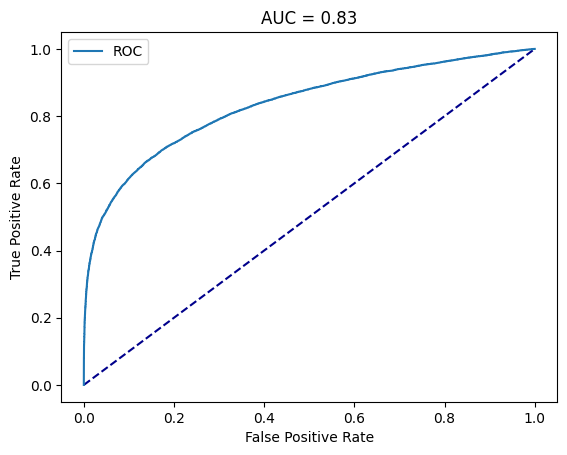

In [21]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax.plot(fpr, tpr, label="ROC")
ax.set_title(f'AUC = {np.round(auc, 2)}', size=12)
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.legend()
plt.show()

## Model summary

In [24]:
old_model.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  49200     
_________________________________________________________________
lstm_2 (LSTM)                multiple                  80400     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  320064    
_________________________________________________________________
dense_1 (Dense)              multiple                  2080      
_________________________________________________________________
dense_2 (Dense)              multiple                  33     

## Mean and Standard deviation results

In [18]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []
loss_list = []

for i in range(3):
    print(f"Weight {i + 1}")
    
    old_model.load_weights(f"weights/Experiment 2/large/LSTM_large{i+1}.h5")
    _, _, precision, recall, f1, _ = conf_m(old_model, test_dataset)
    loss, accuracy = test(old_model, test_dataset, loss_function=tf.keras.losses.BinaryCrossentropy())
    _, _, auc = roc(old_model, test_dataset)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc)
    loss_list.append(loss)

Weight 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Weight 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Weight 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [22]:
print("Accuracy =", np.mean(accuracy_list), "+/-", np.std(accuracy_list))
print("Precision =", np.mean(precision_list), "+/-", np.std(precision_list))
print("Recall =", np.mean(recall_list), "+/-", np.std(recall_list))
print("F1 =", np.mean(f1_list), "+/-", np.std(f1_list))
print("AUC =", np.mean(auc_list), "+/-", np.std(auc_list))
print("Loss =", np.mean(loss_list), "+/-", np.std(loss_list))

Accuracy = 0.8536383703357281 +/- 0.01653945472881087
Precision = 0.8478184112282424 +/- 0.021000239370447482
Recall = 0.860010606094085 +/- 0.030043679207945956
F1 = 0.85345380526181 +/- 0.017581642254853026
AUC = 0.9293655259238632 +/- 0.014796146118918198
Loss = 0.34979784 +/- 0.040128358


## Time performance tests

### Test inference time on current machine

In [23]:
ex_sample = None
ex_label = None
for samp, lbl in val_dataset.take(1):
    ex_sample = samp[0, :, :, :]
    ex_label = lbl[0]

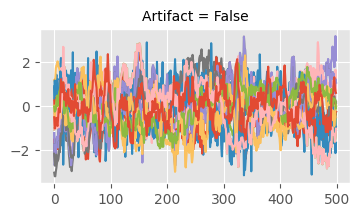

In [24]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(ex_sample[:, :, 0])
ax.set_title(f'Artifact = {tf.cast(label[0], tf.bool)}', fontsize=10)
plt.show()

In [26]:
%%timeit -n 10 -r 1000

# process the prediction
prediction = old_model(tf.expand_dims(ex_sample, axis=0))

7.06 ms ± 171 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)
